In [1]:
# import packages

import pickle, pprint
import numpy as np

In [2]:
# load data

pkl_file = open('zo1_graph_timelapse_sample_v2.pkl','rb')
data1 = pickle.load(pkl_file)

# Data Visualization

In [3]:
# choose time step

t = 16

Text(0.5,0.98,'Time step = 16')

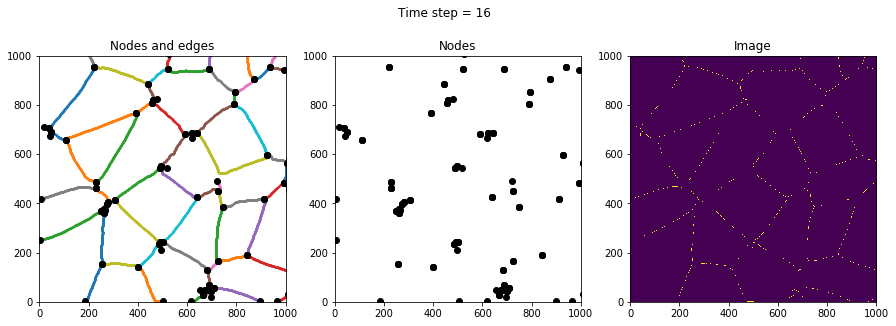

In [4]:
# plot edge, node and image data at time step t

import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage

%matplotlib inline
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

# plot nodes and edges
posit = [i for i in range(len(data1[2][t]))]

for pos in posit:
    l = len(data1[2][t][pos][:])-1
    # all edges/branches
    ax.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.', markersize = 2)
    
    # nodes (endpoints)
    ax.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
    ax.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')

# plot nodes
for pos in posit:
    l = len(data1[2][t][pos][:])-1
    ax2.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0],'ok')
    ax2.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0],'ok')

# plot image
img = ndimage.rotate(data1[0][t] == 2, 0)
# plot the image with origin at lower left
ax3.imshow(img, origin = 'lower')

titles = ['Nodes and edges','Nodes', 'Image' ]
# axis stuff
axes = list([ax, ax2, ax3])
for j,ax in enumerate(axes):
    ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
    ax.set_title(titles[j])

fig.suptitle("Time step = %d" %t , fontsize=12)



# Curve fitting

Now we put the nodes and edges into our data structure and perform curve fits to find radius

In [5]:
# put data into node and edge classes and perform curve fitting

import sys
sys.path.insert(0, '../cell_soap/')
from cell_describe import node, edge
from fitting import fit

# posit is the list of branches
posit = [i for i in range(len(data1[2][t]))]

#list of nodes and edges to be updated
nodes, edges = [], []

for pos in posit:
    # l is the index of the last point on a branch
    l = len(data1[2][t][pos][:])-1
    
    # node_a is the node at location 0 of a branch
    node_a = node((data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0]))
    nodes.append(node_a)
    
    # node_b is the node at location l (last) of a branch
    node_b = node((data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0]))
    nodes.append(node_b)
    
    # x and y are co-ordinates along a branch (dataset). 
    x = data1[1][t][data1[2][t][pos][:],1]
    y = data1[1][t][data1[2][t][pos][:],0]
    
    # we want to fit a curve to this. Use least squares fitting.
    # output is radius and x,y co-ordinates of the centre of circle
    radius, xc, yc = fit(x,y)
    
    # Check the direction of the curve. Do this by performing cross product 
    x1, y1, x2, y2 = x[0], y[0], x[-1], y[-1]
    v1 = [x1 - xc, y1 - yc]
    v2 = [x2 - xc, y2 - yc]
    cr = np.cross(v1, v2)
    a = 0.5*np.linalg.norm(np.subtract([x2,y2], [x1,y1])) # dist to midpoint

    # check if radius is 0
    if radius > 0:
        # same assertion thats in the class
        if a < radius:
            # if cross product is negative, then we want to go from node_a to node_b
            # if positive, we want to go from node_b to node_a
            if cr > 0:
                ed = edge(node_b, node_a, radius)
            else:
                ed = edge(node_a, node_b, radius)
    else:
        # if no radius, leave as None
        ed = edge(node_a, node_b, None)
    edges.append(ed)

Now we have a list of nodes and edges. Lets plot them and original data to see if the curve fit is working


Text(0.5,1,'Curve fits + Original data')

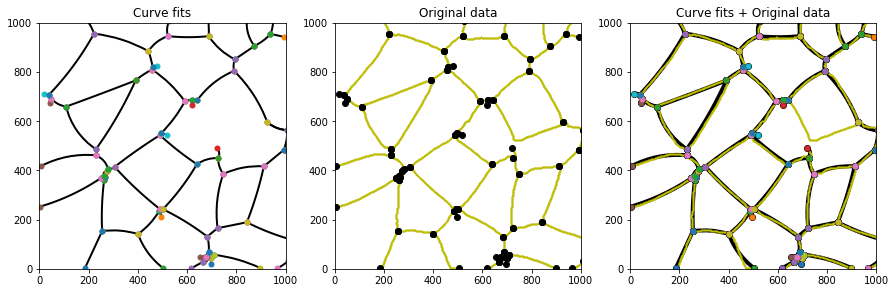

In [6]:
# check edge and node plots from class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits')
ax2.set_title('Curve fits + Original data')

# Data post processing

Looks like theres a lot of nodes that are really close to each other. Need to do some post processing to combine them

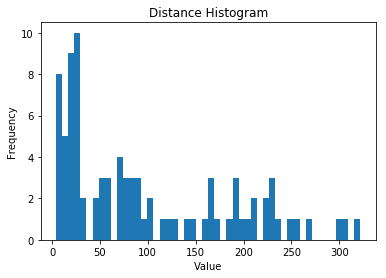

Cutoff length is 23.20298500260939


In [7]:
# choose a cutoff Euclidian distance below which we ignore all edges
# plot histogram of all edge distances 

import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(1,1)
distances = [e.straight_length for e in edges]
plt.title("Distance Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

b = 50
# ax.hist(distances, bins=50)
ax.hist(distances, bins = b)
plt.show()
ax.set_aspect(1)
y, x, _ = ax.hist(distances, bins = b)

# choose a cutoff edge length where we merge nodes together
cutoff = x[np.argmax(y)]
# print(x[np.argmax(y)])
# print(y.max())
print('Cutoff length is', cutoff)

Now we want to delete all edges of length smaller than the cutoff

In [10]:
# find bad edges and nodes and remove them from the list 



print('Original number of edges and nodes are:',len(edges), len(nodes))
cutoff = 80

bad_edges = [e for e in edges if e.straight_length <= cutoff]


for e in bad_edges:
    for n in nodes:
        if n in e.nodes:
            n.edges.remove(e)
    edges.remove(e)
    
n = len(nodes)
i = 0
while i < n:
    element = nodes[i]
    if not element.edges:
        del nodes[i]
        n = n-1
    else:
        i = i + 1



# for n in nodes_old:
#     if not n.edges:
#         nodes.remove(n)
print('New number of edges and nodes are:',len(edges), len(nodes))

Original number of edges and nodes are: 66 130
New number of edges and nodes are: 40 78


Lets plot it

Text(0.5,1,'Curve fits with removed edges + Original data')

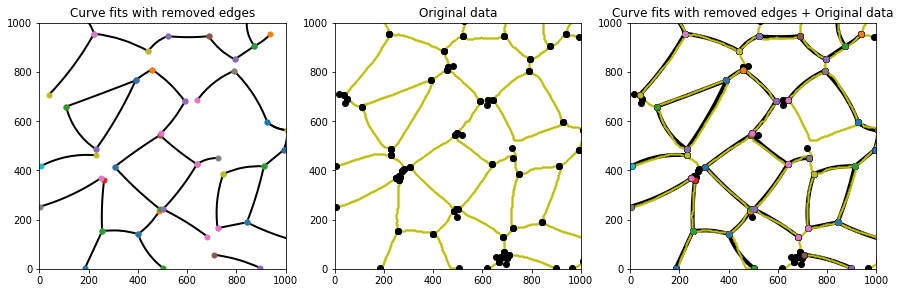

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed edges')
ax2.set_title('Curve fits with removed edges + Original data')

Repeat above process till edges look reasonably connected

# Cell finding

Next we look for cells

In [12]:
# Perform cell finding code. Output is cells
#type specifies direction of cell finding. 0 for minimum positive angle and 1 for maximum negative angle
# both types are implemented
# num specifies the final node (node_b if we start from node_a)
from main import main

type = 0
num = 1
cells = []

for ed in edges:
    con_edges0 = ed.connected_edges[0]
    angles1 = [ed.edge_angle(e2)  for e2 in con_edges0]
    cells = main(ed, angles1, con_edges0, cells, type, num)
    type = 1
    cells = main(ed, angles1, con_edges0, cells, type, num)

In [14]:
cells

[]

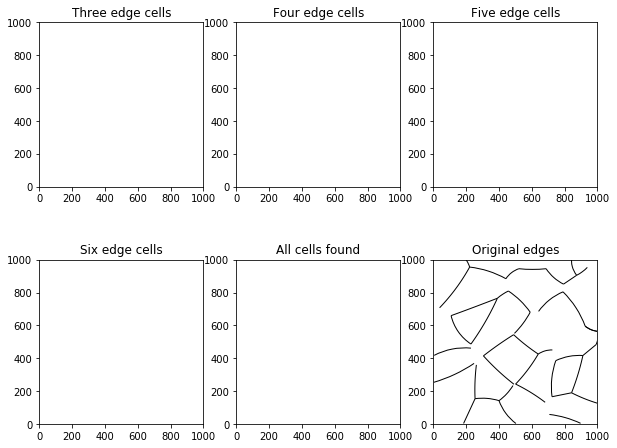

In [13]:
# plot all cells

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2,3,figsize=(10,8))
[cell.plot(axes[0, 0]) for cell in cells if len(cell.edges) == 3];
[cell.plot(axes[0, 1]) for cell in cells if len(cell.edges) == 4];
[cell.plot(axes[0,2]) for cell in cells if len(cell.edges) == 5];
[cell.plot(axes[1,0]) for cell in cells if len(cell.edges) == 6];
[cell.plot(axes[1,1]) for cell in cells if len(cell.edges) == 5];
[cell.plot(axes[1,1]) for cell in cells if len(cell.edges) == 4];
[cell.plot(axes[1,1]) for cell in cells if len(cell.edges) == 3];
[cell.plot(axes[1,1]) for cell in cells if len(cell.edges) == 6];
[cell.plot(axes[1,1]) for cell in cells if len(cell.edges) == 7];
#[cell.plot(axes[2,1]) for cell in cell_seven];
[ed.plot(axes[1,2]) for ed in edges];

[a.set(xlim=(0,1000), ylim=(0, 1000), aspect=1) for a in axes[1,:]]
[a.set(xlim=(0,1000), ylim=(0, 1000), aspect=1) for a in axes[0,:]]
#[a.set(xlim=(-1,1), ylim=(-1, 1), aspect=1) for a in axes[2,:]]
axes[1,2].set_title("Original edges")
axes[0,0].set_title("Three edge cells")
axes[0,1].set_title("Four edge cells")
axes[0,2].set_title("Five edge cells")
axes[1,0].set_title("Six edge cells")
#axes[2,1].set_title("Seven edge cells")
axes[1,1].set_title("All cells found")
plt.show()

data1[1] is the list of (x,y) locations of each node at 31 time steps. So data[1][0] is for time step 0. In each time step, there is a list of 10726 locations each with an x and y co-ordinate

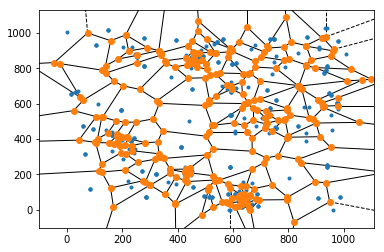

[(0, 1000), (0, 1000)]

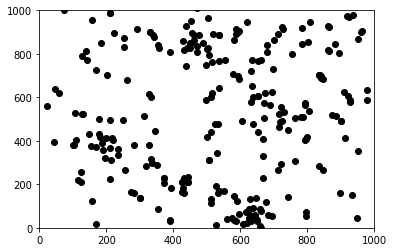

In [57]:
# try voronoi diagram
from scipy.spatial import Voronoi, voronoi_plot_2d
points = []
for n in nodes:
    points.append([n.loc[0],n.loc[1]])
points = np.array(points)



vor = Voronoi(points)
voronoi_plot_2d(vor)
plt.show()

fig, ax = plt.subplots(1,1)

for a in vor.vertices:
    ax.plot(a[0], a[1],'ok')
ax.set(xlim = [0, 1000], ylim = [0,1000])
                

3

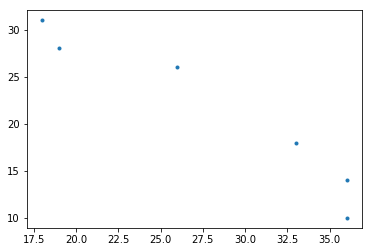

In [50]:
#! python
# Coordinates of the 2D points
x = np.array([36, 36, 19, 18, 33, 26])
y = np.array([14, 10, 28, 31, 18, 26])

x_m = np.mean(x)
y_m = np.mean(y)
plt.plot(x,y,'.')
np.argmin(x)

In [53]:
#! python
#  == METHOD 2 ==
from scipy import optimize

method_2 = "leastsq"

def calc_R(xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2(c):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(*c)
    return Ri - Ri.mean()

center_estimate = x_m, y_m
center_2, ier = optimize.leastsq(f_2, center_estimate)

xc_2, yc_2 = center_2
Ri_2       = calc_R(*center_2)
R_2        = Ri_2.mean()
residu_2   = np.sum((Ri_2 - R_2)**2)

theta1 = np.rad2deg(np.arctan2(y[np.argmax(x)]-yc_2, x[np.argmax(x)]-xc_2)) # starting angle
theta2 = np.rad2deg(np.arctan2(y[np.argmin(x)]-yc_2, x[np.argmin(x)]-xc_2)) 

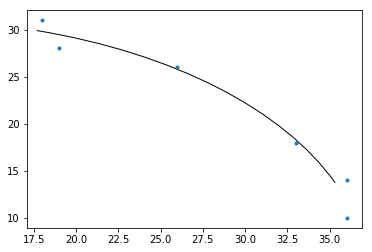

In [54]:
fig, ax = plt.subplots(1,1)
plt.plot(x,y,'.')
patch = matplotlib.patches.Arc(center_2, 2*R_2, 2*R_2,
                                           0, theta1, theta2)
ax.add_patch(patch)
plt.show()

In [1]:
import numpy as np
x = np.array([36, 36, 19, 18, 33, 26])
y = np.array([14, 10, 28, 31, 18, 26])
import sys
sys.path.insert(0, '../cell_soap/')
from fitting import fit

In [2]:
R = fit(x,y)

In [3]:
R

27.35040767420324